# Table of Contents

1. [Import stuff](#import_everything)
2. [Set whether these analyses are done for this analysis or not](#set_whether_these_analyses_are_done_for_this_analysis_or_not)
3. [Load data](#os.path.exists_checkpoint_fig_dir__load_data)
    1. [Set values for indexing](#Set_some_values_for_indexing_etc)
    2. [Rearranging data](#Rearranging_data)
4. [Start Analyses](#Start_Analyses)
5. [Learning Accuracy (SSE ) over time](#Learning_Accuracy_SSE_over_time)
    1. [Print checkpoint](#Checkpoint_0:_istheoutputcolorshowncorrectlythroughoutthelearningtask)
    2. [Visualize the output layer at each epoch](#Visualizetheoutputlayerateachepoch)
6. [Correlation Analysis](#Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask)
    1. [Plot Within Pair Correlation Over Time](#Plot_Within_Pair_Correlation_Over_Time)
    2. [Is the low/med/high within pair correlation in the right order in the color layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_color_layer?)
    3. [Is the low/med/high within pair correlation in the right order in the hidden layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?)
    4. [MDS](#MDS)
7. [Difference score](#within-pair_correlation_minus_across-pair_correlation._Done_in_the_hidden_layer._)
8. [Center of mass](#CENTER_OF_MASS)
    1. [Scatter plot hidden center of mass repulsion vs. output center of mass repulsion](#Scatter_plot_hidden_center_of_mass_repulsion_vs_output_center_of_mass_repulsion)
9. [Analyze Face Layer in Association Task](#Face_Association_Task)
12. [Add necessary checkpoint info](#Add_necessary_checkpoint_info)
13. [Save](#Save)



## Imports
<a id='import_everything'></a>

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import os as os
import sys as sys
from collections import defaultdict
import time
from IPython.display import display
from sklearn.manifold import MDS

import scipy.stats as stats
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from datetime import datetime
import traceback
import pprint
import cProfile, pstats, io
from matplotlib.lines import Line2D

codeprofiler = cProfile.Profile()

pp = pprint.PrettyPrinter(indent=4)

idx = pd.IndexSlice

sns.set_style(style='white')
pd.set_option('display.max_columns', 30)


In [2]:
print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv))
print('---')
from_cmdLine = sys.argv[-1]
print(from_cmdLine)

print('---', flush=True)


Number of arguments: 3 arguments.
Argument List: ['/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-39480539-e65c-435e-a851-e6de2bdb8df5.json']
---
/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-39480539-e65c-435e-a851-e6de2bdb8df5.json
---


In [3]:
if from_cmdLine == 'cmd' :
    data_file = sys.argv[-2]
    print('using command line to set data')
    dataDir = data_file + '/'
else :
    print('using script to set data')

    #Set the date of the data we want to look at:

    data_file = '2022-02-05-20-11-29' #<-testing
    dataDir = 'data/' + data_file + '/'


using script to set data


### set whether these analyses are done for this analysis or not
<a id='set_whether_these_analyses_are_done_for_this_analysis_or_not'></a>

In [4]:
test_trial_done = 1
train_trial_done = 1
test_cycle_done = 0
train_cycle_done = 0

#Do you want this code to spit out a good NMPH curve based on the activity? 
#For regular analyses, that code chunk should get skipped.
calculate_learning_curve = 0



# Load Data
<a id='os.path.exists_checkpoint_fig_dir__load_data'></a>

In [5]:
# Create the correct directories
figDir = dataDir + 'fig/'
checkpoint_fig_dir = figDir + 'checkpoints/'
results_fig_dir = figDir + 'results/'
eps_dir = results_fig_dir + 'eps_files/'

if not os.path.exists(figDir) :
    os.mkdir(figDir)
    
if not os.path.exists(results_fig_dir) :
    os.mkdir(results_fig_dir)
    
if not os.path.exists(checkpoint_fig_dir) :
    os.mkdir(checkpoint_fig_dir)
    
if not os.path.exists(eps_dir) :
    os.mkdir(eps_dir)

if not os.path.exists(checkpoint_fig_dir + 'cycle_plots/') :
    os.mkdir(checkpoint_fig_dir + 'cycle_plots/')

In [6]:
codeprofiler.enable()
print('code profiler')

code profiler


In [7]:
data_epc = pd.read_csv(dataDir + 'color_diff_Base_epc.csv', sep = '\t')

In [8]:
if (test_trial_done == 1) :
    print('loading test trial data')
    
    data_test = pd.read_csv(dataDir + 'color_diff_Base_tsttrl.csv', sep = '\t')
    data_test = data_test[data_test['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne
    assert set(data_test['$TrialName']) == {'med1', 'med2'}, "Trial name must be either med1 or med2"
    
data_test[(data_test["|Epoch"] <1)]

loading test trial data


,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0.000,0.0000,0.9997,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.000,0.0000,0.9977,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,0,TaskColorRecall,TestColorAll,0,med1,0,0.000,0.0000,0.9982,0,0,0,1,1,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,0,TaskColorRecall,TestColorAll,1,med2,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4,0,0,TaskColorRecall,TestFaceAll,0,med1,1,3.611,0.6019,-0.9004,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,19,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1560,19,0,TaskColorRecall,TestColorAll,0,med1,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1561,19,0,TaskColorRecall,TestColorAll,1,med2,0,0.000,0.0000,1.0000,0,0,0,1,1,...,3.807000e-19,1.389000e-23,3.650000e-31,4.959000e-42,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1562,19,0,TaskColorRecall,TestFaceAll,0,med1,1,2.190,0.3651,0.4037,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [9]:
def fill_dummy_stim(data_test, task_type) :


    if task_type == 'test' :
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest']]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '|Trial', '$TrialName']]

    elif task_type == 'train':
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', ]]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '|Trial', '$TrialName']]

    numeric_columns = [c for c in remaining_columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']]
    ### DF 1:
    #make a df with the columns that we want to be not-zero for our dummy values
    df_1 = data_test[first_columns].drop_duplicates()

    #add a dummy column so that we can do an outer merge later
    df_1['dummy'] = 1
    
    ### DF2 :
    #make a second df with just the trial number, trial names, and all the columns that will be zero
    df_2 = pd.DataFrame(columns = remaining_columns)
    
    #add the rows taht are zeroed out for each of our fake stimuli
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)


    #add in a column with the values of each stim. This df now has 4 rows (one for each of our fake stim)
    df_2.insert(0, "$TrialName", ['low1','low2','high1','high2'], False) 
    df_2.insert(0, "|Trial", [2,3,4,5], False) 
    
    #add a dummy column so that we can do an outer merge
    df_2['dummy'] = 1
    df_2[numeric_columns] = df_2[numeric_columns].apply(pd.to_numeric)
    #do an outer merge of the two dfs. This is everything we need for the fake stim.
    fake_stim = pd.merge(df_1, df_2, on = 'dummy', how = 'outer')
    fake_stim = fake_stim.drop(['dummy'], axis = 1)

    #append to orginal dataframe. Sort.
    data_test = data_test.append(fake_stim)
    data_test = data_test.sort_values(by = ['|Run', '|Epoch', '|Trial']).reset_index(drop = True)

    return data_test


In [10]:
if 'high1' in data_test['$TrialName'].unique() :
    pass
else:
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TEST DATA')
    tick = time.time()
    data_test = fill_dummy_stim(data_test, 'test')
    print(f"fill_dummy_stim took {time.time() - tick} s")
    print('done', flush=True)


LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TEST DATA
fill_dummy_stim took 0.36907410621643066 s
done


In [11]:
if (train_trial_done == 1) :
    print('loading train trial data')
    
    data_train = pd.read_csv(dataDir + 'color_diff_Base_trntrl.csv', sep = '\t')
    data_train = data_train[data_train['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne

    print('done')
    
data_train

loading train trial data
done


,|Run,|Epoch,$CurrentTask,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,#Output_SSE,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,0,TaskColorRecall,0,med2,0,0,0,0.9972,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,0,TaskColorRecall,1,med1,0,0,0,0.8954,0,0,0,1,1,0.4321,...,1.750000e-40,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,7.194000e-38,9.595000e-42,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.055000e-41,1.401000e-45,1.401000e-45,3.064000e-38
2,0,1,TaskColorRecall,0,med2,0,0,0,0.9993,0,0,0,1,0,0.0000,...,2.090000e-40,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,1,TaskColorRecall,1,med1,0,0,0,0.9997,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4,0,2,TaskColorRecall,0,med2,0,0,0,0.9993,0,0,0,1,0,0.0000,...,1.637000e-26,4.823000e-35,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,19,17,TaskColorRecall,1,med1,0,0,0,0.9997,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
796,19,18,TaskColorRecall,0,med1,0,0,0,0.9997,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
797,19,18,TaskColorRecall,1,med2,0,0,0,1.0000,0,0,0,1,0,0.0000,...,6.893000e-11,2.154000e-15,8.773000e-23,8.066000e-34,1.245000e-32,2.866000e-32,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
798,19,19,TaskColorRecall,0,med2,0,0,0,1.0000,0,0,0,1,0,0.0000,...,6.893000e-11,2.154000e-15,8.773000e-23,8.066000e-34,1.245000e-32,2.866000e-32,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [12]:
if 'high1' in data_train['$TrialName'].unique() :
        ;
else :
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TRAIN DATA')
    
    tick = time.time()
    data_train = fill_dummy_stim(data_train, 'train')
    print(f"fill_dummy_stim took {time.time() - tick} s")
    print('done')


LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TRAIN DATA
fill_dummy_stim took 32.92051100730896 s
done


In [13]:
if (train_cycle_done == 1) :
    print('loading train cycle data')
    data_trn_cyc = pd.read_csv(dataDir + 'color_diff_Base_trncyc.csv', sep = '\t')
    data_trn_cyc.head(200)
    print('done')


In [14]:
if (test_cycle_done == 1) : 
    print('loading test cycle data')
    data_tst_cyc = pd.read_csv(dataDir +'color_diff_Base_tstcyc.csv', sep = '\t')
    data_tst_cyc.head(200)
    print('done')

In [15]:
codeprofiler.disable()


#### Set some values for indexing etc
<a id='Set_some_values_for_indexing_etc'></a>

In [16]:
#set values for start and endpoints of output layer and hidden layer to use for indexing
numPairs = 3

face_Start_AvgSLrn = '#FaceAvgSLrn[4:0,0,0,0]<4:2,1,1,3>'
face_End_AvgSLrn = '#FaceAvgSLrn[4:1,0,0,2]'

outputM_Start = '#OutActM[2:0,0]<2:1,50>'
outputM_End = '#OutActM[2:0,49]'


faceM_Start = '#FaceActM[4:0,0,0,0]<4:2,1,1,3>'
faceM_End = '#FaceActM[4:1,0,0,2]'

output_Start = '#OutAct[2:0,0]<2:1,50>'
output_End = '#OutAct[2:0,49]'

output_Start_AvgS = '#OutAvgS[2:0,0]<2:1,50>'
output_End_AvgS = '#OutAvgS[2:0,49]'

output_Start_AvgM = '#OutAvgM[2:0,0]<2:1,50>'
output_End_AvgM = '#OutAvgM[2:0,49]'

output_Start_AvgSLrn = '#OutAvgSLrn[2:0,0]<2:1,50>'
output_End_AvgSLrn = '#OutAvgSLrn[2:0,49]'

filter_colM = [col for col in data_train if col.startswith('#OutActM[')]
filter_HiddM = [col for col in data_train if col.startswith('#HiddenActM[')]
filter_col_AvgSLrn = [col for col in data_train if col.startswith('#OutAvgSLrn[')]
filter_Hidden_AvgSLrn = [col for col in data_train if col.startswith('#HiddenAvgSLrn[')]
filter_colP = [col for col in data_train if col.startswith('#OutActP[')]
filter_HiddenP = [col for col in data_train if col.startswith('#HiddenActP[')]
if 'data_trn_cyc' in locals():
    filter_col = [col for col in data_trn_cyc if col.startswith('#OutAct[')]
    filter_face = [col for col in data_trn_cyc if col.startswith('#FaceAct[')]


hidden_dimensions = 1

if hidden_dimensions == 1 :
    study_task_run = 0;
elif hidden_dimensions == 2 :
    study_task_run = 1;
    
if hidden_dimensions == 2 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:10,10>'    
    hiddenM_End = '#HiddenActM[2:9,9]'

    hidden_Start = '#HiddenAct[2:0,0]<2:10,10>'    
    hidden_End = '#HiddenAct[2:9,9]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:10,10>'    
    hidden_End_AvgL = '#HiddenAvgL[2:9,9]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:10,10>'    
    hidden_End_AvgM = '#HiddenAvgM[2:9,9]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:10,10>'    
    hidden_End_AvgS = '#HiddenAvgS[2:9,9]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:10,10>'    
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:9,9]'
    
    
elif hidden_dimensions == 1 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:1,50>'  
    hiddenM_End = '#HiddenActM[2:0,49]'

    hidden_Start = '#HiddenAct[2:0,0]<2:1,50>'  
    hidden_End = '#HiddenAct[2:0,49]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:1,50>'   
    hidden_End_AvgL = '#HiddenAvgL[2:0,49]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:1,50>'    
    hidden_End_AvgM = '#HiddenAvgM[2:0,49]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:1,50>'    
    hidden_End_AvgS = '#HiddenAvgS[2:0,49]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:1,50>'  
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:0,49]'



hidden_to_hidden_weights_Start = '#HiddentoHiddenWeights[1:0]<1:9900>'
hidden_to_hidden_weights_End = '#HiddentoHiddenWeights[1:9899]'

output_to_hidden_weights_Start = '#OutputtoHiddenWeights[1:0]<1:5000>'
output_to_hidden_weights_End = '#OutputtoHiddenWeights[1:4999]'

hidden_to_output_weights_Start = '#HiddentoOutputWeights[1:0]<1:5000>'
hidden_to_output_weights_End = '#HiddentoOutputWeights[1:4999]'

hidden_to_hidden_DWt_Start = '#HiddentoHiddenDWt[1:0]<1:9900>'
hidden_to_hidden_DWt_End = '#HiddentoHiddenDWt[1:9899]'

output_to_hidden_DWt_Start = '#OutputtoHiddenDWt[1:0]<1:5000>'
output_to_hidden_DWt_End = '#OutputtoHiddenDWt[1:4999]'

hidden_to_output_DWt_Start = '#HiddentoOutputDWt[1:0]<1:5000>'
hidden_to_output_DWt_End = '#HiddentoOutputDWt[1:4999]'

face_to_hidden_DWt_Start = '#FacetoHiddenDWt[1:0]<1:600>'
face_to_hidden_DWt_End = '#FacetoHiddenDWt[1:599]'

hidden_to_face_DWt_Start = '#HiddentoFaceDWt[1:0]<1:600>'
hidden_to_face_DWt_End = '#HiddentoFaceDWt[1:599]'

obj_Start = '#ObjAct[2:0,0]<2:1,3>'
obj_End = '#ObjAct[2:0,2]'

#hidden net input:
hidden_ge_start = '#HiddenGe[2:0,0]<2:10,10>'
hidden_ge_end = '#HiddenGe[2:9,9]'

if (numPairs == 2) :
    stim_names = ['small1', 'small2', 'small3', 'small4']
    
elif (numPairs == 3) :
    stim_names = ['low1','low2','med1', 'med2', 'high1','high2']
    
medium_only_analysis = True

if medium_only_analysis == True :
    stim_names = ['med1', 'med2']

if (numPairs == 2) :
    #post- pools:

    face_Start = '#FaceAct[4:0,0,0,0]<4:2,1,1,2>'
    face_End = '#FaceAct[4:1,0,0,1]'

    #face net input:
    face_ge_start = '#FaceGe[4:0,0,0,0]<4:2,1,1,2>'
    face_ge_end = '#FaceGe[4:1,0,0,1]'

elif (numPairs==3) :
    face_Start = '#FaceAct[4:0,0,0,0]<4:2,1,1,3>'
    face_End = '#FaceAct[4:1,0,0,2]'

    #face net input:
    face_ge_start = '#FaceGe[4:0,0,0,0]<4:2,1,1,3>'
    face_ge_end = '#FaceGe[4:1,0,0,2]'


#dictionary for face layer to use for later analyses

if (numPairs == 2) :
    
    faceKey = {'#FaceAct[4:0,0,0,0]<4:2,1,1,2>' : 'small2', '#FaceAct[4:0,0,0,1]' : 'small4', '#FaceAct[4:1,0,0,0]': 'small1', '#FaceAct[4:1,0,0,1]': 'small3'}
    faceKey_ge = {'#FaceGe[4:0,0,0,0]<4:2,1,1,2>' : 'small2 Ge', '#FaceGe[4:0,0,0,1]' : 'small4 Ge', '#FaceGe[4:1,0,0,0]': 'small1 Ge', '#FaceGe[4:1,0,0,1]': 'small3 Ge'}

elif (numPairs ==3) :
    faceKey = {'#FaceAct[4:0,0,0,0]<4:2,1,1,3>' : 'low2', '#FaceAct[4:0,0,0,1]' : 'med2', '#FaceAct[4:1,0,0,0]': 'low1', '#FaceAct[4:1,0,0,1]': 'med1', '#FaceAct[4:1,0,0,2]': 'high1', '#FaceAct[4:0,0,0,2]': 'high2'}
    faceKey_ge = {'#FaceGe[4:0,0,0,0]<4:2,1,1,3>' : 'low2 Ge', '#FaceGe[4:0,0,0,1]' : 'med2 Ge', '#FaceGe[4:1,0,0,0]': 'low1 Ge', '#FaceGe[4:1,0,0,1]': 'med1 Ge', '#FaceGe[4:1,0,0,2]': 'high1 Ge', '#FaceGe[4:0,0,0,2]': 'high2 Ge'}
    faceKeyM = {'#FaceActM[4:0,0,0,0]<4:2,1,1,3>' : 'low2_ActM', '#FaceActM[4:0,0,0,1]' : 'med2_ActM', '#FaceActM[4:1,0,0,0]': 'low1_ActM', '#FaceActM[4:1,0,0,1]': 'med1_ActM', '#FaceActM[4:1,0,0,2]': 'high1_ActM', '#FaceActM[4:0,0,0,2]': 'high2_ActM'}
    
faceKey_AvgSLrn = {key.replace("Act", "AvgSLrn"): value for key, value in faceKey.items()}

    
nepochs = max(data_test['|Epoch'])
nruns = max(data_test[data_test['|Epoch']==nepochs]['|Run']) # only get maximum run that reached the end. 
num_runs_scheduled = sys.argv[-3]
try:
    num_runs_scheduled = int(num_runs_scheduled)
except:
    num_runs_scheduled = None
if num_runs_scheduled is not None:
    assert nruns+1 == num_runs_scheduled, "The total number of runs {nruns+1} does not match the total number of runs scheduled {num_runs_scheduled}. Exiting without creating graphs now !"
try: 
    epoch_end_ColorWOOsc = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
except:
    epoch_end_ColorWOOsc = 0
    print('could not find any ColorWOOSC trials. May want to check this out.')

# epoch_end_Face = max(data_test[data_test['$CurrentTask'] == 'TaskFaceRecall']['|Epoch'])
# epoch_end_initial = max(epoch_end_ColorWOOsc,epoch_end_Face)
epoch_end_initial = -1 # was epoch_end_ColorWOOsc

if (numPairs == 2) :
    face_palette = {'small1' : (0.6, .3, .6), 
                       'small2' : (0.8, .5, .8), 
                       'small3' : (0.3, .5, .6),
                       'small4' : (0.5, .7, .8)}

    face_palette_ge = {'small1 Ge' : (0.6, .3, .6), 
                       'small2 Ge' : (0.8, .5, .8), 
                       'small3 Ge' : (0.3, .5, .6),
                       'small4 Ge' : (0.5, .7, .8)}
    
    hidden_palette = {'small1' : (0.6, .3, .6), 
                      'small2' : (0.8, .5, .8), 
                      'small12': (1, .7, 1),
                      'small3' : (0., .5, .6),
                      'small4' : (0.5, .7, .8),
                      'small34' : (0.6, .85, .95),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    hidd_order=["small1", "small2", "small12", 'small3','small4','small34','cross-pair', 'not active']
    
elif (numPairs == 3) :
    face_palette = {'low1' : (0.6, .3, .6), 
                   'low2' : (0.8, .5, .8), 
                   'med1' : (0.2, .3, .6),
                   'med2' : (0.4, .5, .8),
                   'high1': (.4, .7, .4),
                   'high2' : (.6, .9, .6)}

    face_palette_ge = {'low1 Ge' : (0.6, .3, .6), 
                   'low2 Ge' : (0.8, .5, .8), 
                   'med1 Ge' : (0.2, .3, .6),
                   'med2 Ge' : (0.4, .5, .8),
                   'high1 Ge': (.4, .7, .4),
                   'high2 Ge' : (.6, .9, .6)}
    
    category_palette = {'low' : (.7, .4, .7),
                       'med': (.3, .4, .7),
                       'high': (.5, .8, .5)}
    hidden_palette = {'low1' : (0.6, .3, .6), 
                      'low2' : (0.8, .5, .8), 
                      'low1+2': (1, .7, 1),
                      'med1' : (0.2, .3, .6),
                      'med2' : (0.4, .5, .8),
                      'med1+2' : (0.6, .7, .9),
                      'high1' : (0.4, .7, .4),
                      'high2' : (0.6, .9, .6),
                      'high1+2' : (0.8, 1, .8),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    
    correl_palette = {'high1-high2': (.5, .8, .5),
                      'med1-med2' : (0.6, .7, .9),
                      'low1-low2' : (.7, .4, .7),
                      'across': (.7, .5, .5)
        
    }

    hidd_order=["low1", "low2", "low1+2", 'med1','med2','med1+2','high1','high2','high1+2','cross-pair', 'not active']

print(f"setting variables took {time.time() - tick} s", flush=True)

setting variables took 33.045892000198364 s


In [17]:
# figure out what type of tasks were done
print("figure out what type of tasks were done", flush=True)

color_task_run = os.path.exists(dataDir + 'color_diff_Base_Params_TaskColorRecall.csv')
face_task_run = os.path.exists(dataDir + 'color_diff_Base_Params_TaskFaceRecall.csv')


if color_task_run and not face_task_run :
    task_run = 'just_color'
elif color_task_run and face_task_run :
    task_run = 'interleaved'
elif not color_task_run and face_task_run :
    task_run = 'just_face'
    
else:
    task_run = 0
    error('something went wrong. Task not run properly.')

    


figure out what type of tasks were done


#### decide if you want to run all the dwt, XCAL, weight analysis stuff (useful when choosing parameters, but not needed for general analysis)

In [18]:

if task_run == 'just_face':
    run_learning_analyses = 0
    dwt_coprod_plot = 1 # add in dwt vs. co_prod plot for the paper
else:
    run_learning_analyses = 0 #usually would make this 1, but skipping for now
    dwt_coprod_plot = 1 # add in dwt vs. co_prod plot for the paper

In [19]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

def competitor_trial(trial_name) :
# if you have med1 as an input argument, it will return med2

    overlap_type = trial_name[:-1]
    pair_unit = int(trial_name[-1])
    other_unit = pair_unit % 2 + 1
    other_trial = overlap_type + str(other_unit)
    return other_trial

def get_parameter_values():
    if task_run != 'just_face':
        params_file = dataDir + "color_diff_Base_Params_TaskColorRecall.csv"
    else: 
        params_file = dataDir + "color_diff_Base_Params_TaskFaceRecall.csv"
        
    Layer_ThrP_NMPH_dict = {}
    Layer_Drev_dict = {}
    Layer_DThr_dict = {}
    LTD_mult_TaskColorRecall = None
    Layer_OscAmnt_dict = {}
    Layer_Gi_dict = {}
    overlap_dict = {}
    
    parameter_values = {}

    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:6] == "Layer:": # get layer name
                layername = line.split(" ")[-1][:-1]

            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
                
            if "OscAmnt" in line: # get oscAmnt
                Layer_OscAmnt_dict[layername] = float(line.split(" ")[-2])
            if "Layer" in line and "Gi" in line:
                Layer_Gi_dict[layername] = float(line.split(" ")[9])
                
            if "ThrP_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_ThrP_NMPH_dict[prjnname] = float(line.split(" ")[-8])
            if "DRev_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_Drev_dict[prjnname] = float(line.split(" ")[-20])
            if (LTD_mult_TaskColorRecall == None) and ('LTD_mult' in line):
                LTD_mult_TaskColorRecall = float(line.split(" ")[-2])
            if "DThr_NMPH" in line:
                Layer_DThr_dict[prjnname] = float(line.split(" ")[-23])

    if task_run != 'just_face':
        params_file = dataDir + "color_diff_Base_Params_TaskColorRecall.csv"
    else: 
        params_file = dataDir + "color_diff_Base_Params_TaskFaceRecall.csv"
        
    Color_to_Hidden_wt_scale = {}
    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
            if "Rel:" in line: # get AveL value (only occurs 4 times in csv file)
                Color_to_Hidden_wt_scale[prjnname] = float(line.split(" ")[-1])
            if "NumOverlapUnits" in line:
                
                line_split = line.split(" ")
                overlap_dict['numOverlapUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumOverlapUnits" in x][0] + 1])
                overlap_dict['numTotalUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumTotalUnits" in x][0] + 1])
                overlap_dict['overlapType'] = str(overlap_dict['numOverlapUnits']) + '/' + str(overlap_dict['numTotalUnits'])



    parameter_values['ThrP_NMPH'] = Layer_ThrP_NMPH_dict
    parameter_values['DRev_NMPH'] = Layer_Drev_dict
    parameter_values['DThr_NMPH'] = Layer_DThr_dict

    parameter_values['LTD_mult'] = LTD_mult_TaskColorRecall
    parameter_values['Wt_Scale'] = Color_to_Hidden_wt_scale
    parameter_values['OscAmnt'] = Layer_OscAmnt_dict
    parameter_values['Gi'] = Layer_Gi_dict
    
    parameter_values['Num_units_per_layer'] = {
        'Object': 2, 'Face': 6, 'Output': 50
    }
    if hidden_dimensions == 1:
        parameter_values['Num_units_per_layer']['Hidden'] = 50
    elif hidden_dimensions == 2:
        parameter_values['Num_units_per_layer']['Hidden'] = 100

    parameter_values['overlap'] = overlap_dict
    return parameter_values


print('getting parameter values', flush=True)

parameter_values = get_parameter_values() 

getting parameter values


In [20]:
parameter_values['overlap']['overlapType']

'2/6'

In [21]:
parameter_values

{'ThrP_NMPH': {'HiddenToObject': 0.46,
  'HiddenToFace': 0.46,
  'FaceToHidden': 0.46,
  'ObjectToHidden': 0.46,
  'OutputToHidden': 0.6,
  'HiddenToHidden': 0.4,
  'HiddenToOutput': 0.6,
  'OutputToOutput': 0.68},
 'DRev_NMPH': {'HiddenToObject': 0.3,
  'HiddenToFace': 0.3,
  'FaceToHidden': 0.3,
  'ObjectToHidden': 0.3,
  'OutputToHidden': 0.4,
  'HiddenToHidden': 0.24,
  'HiddenToOutput': 0.44,
  'OutputToOutput': 0.6},
 'DThr_NMPH': {'HiddenToObject': 0.2,
  'HiddenToFace': 0.2,
  'FaceToHidden': 0.2,
  'ObjectToHidden': 0.2,
  'OutputToHidden': 0.1,
  'HiddenToHidden': 0.15,
  'HiddenToOutput': 0.1,
  'OutputToOutput': 0.53},
 'LTD_mult': 0.11111112,
 'Wt_Scale': {'HiddenToObject': 1.0,
  'HiddenToFace': 1.0,
  'FaceToHidden': 1.0,
  'ObjectToHidden': 1.0,
  'OutputToHidden': 1.0,
  'HiddenToHidden': 1.0,
  'HiddenToOutput': 1.0,
  'OutputToOutput': 1.0},
 'OscAmnt': {'Object': 0.0, 'Face': 0.22, 'Hidden': 0.11, 'Output': 0.115},
 'Gi': {'Object': 1.8, 'Face': 0.9, 'Hidden': 1.0, 

# Re arranging data
<a id='Rearranging_data'></a>


### Stacked Test and Cycle data
Most of the analyses can be done with these two stacked dataframes. They're arranged so that the columns are the 4 trials, and all the values for each trial are in rows. 

It's a hierarchical dataframe, with multiple indices

for data_test_stacked, the indices are Run, |Epoch, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

for data_test_stacked, the indices are Run, |Epoch, |Cycle, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

You can get a subset by using .loc with each index. i.e.
#### To get the hidden layer activity in the final task for just the first (0th) run, that would be:
    data_test_stacked.loc[('0', 'TaskColorRecall', slice(hidden_Start, hidden_End)),:]
    
#### To get the output layer activity in the baseline task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorWOOsc', slice(outputM_Start, outputM_End)),:]
    
#### To get the SSE in the final task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorRecall', '#SSE'),:]

In [22]:
codeprofiler.enable()


In [23]:
if (test_cycle_done == 1) :
    #make stacked data for cycles. Explanation below.
    data_tst_cyc_stacked = data_tst_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')
    data_tst_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', '$CurrentTest','key']

    data_tst_cyc_stacked


In [24]:
if (train_cycle_done == 1 ) :
    #make stacked data for cycles. Explanation below.
    data_trn_cyc_stacked = data_trn_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')
    data_trn_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', 'key']


In [25]:
if (test_trial_done == 1) :
    #make stacked data. Explanation below.
    data_test_stacked = data_test.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')

    data_test_stacked.head()
    data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'key']
    # data_test_stacked = pd.DataFrame(currData.stack())# data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_test_stacked

In [26]:
data_test[data_test.duplicated(subset= ['|Run','|Epoch','$CurrentTask', '$TrialName'])]

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
7,0,0,TaskColorRecall,TestFaceAll,0,med1,1,3.611,0.6019,-0.9004,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
9,0,0,TaskColorRecall,TestFaceAll,1,med2,1,2.244,0.3740,0.3915,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
11,0,0,TaskColorRecall,TestFaceAll,2,low1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
13,0,0,TaskColorRecall,TestFaceAll,3,low2,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
15,0,0,TaskColorRecall,TestFaceAll,4,high1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911,19,19,TaskColorRecall,TestFaceAll,1,med2,0,0.000,0.0000,0.9997,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4913,19,19,TaskColorRecall,TestFaceAll,2,low1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4915,19,19,TaskColorRecall,TestFaceAll,3,low2,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4917,19,19,TaskColorRecall,TestFaceAll,4,high1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [27]:
if (train_trial_done == 1) :
    #make stacked data. Explanation below.
    data_train_stacked = data_train.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')

    data_train_stacked.head()
    data_train_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_train_stacked

In [28]:
data_train_stacked.head()

$TrialName                                 high1  high2  low1  low2    med1  \
|Run |Epoch $CurrentTask    key                                               
0    0      TaskColorRecall |Trial           4.0    5.0   2.0   3.0  1.0000   
                            #Face_Err        0.0    0.0   0.0   0.0  0.0000   
                            #Face_SSE        0.0    0.0   0.0   0.0  0.0000   
                            #Face_AvgSSE     0.0    0.0   0.0   0.0  0.0000   
                            #Face_CosDiff    0.0    0.0   0.0   0.0  0.8954   

$TrialName                                   med2  
|Run |Epoch $CurrentTask    key                    
0    0      TaskColorRecall |Trial         0.0000  
                            #Face_Err      0.0000  
                            #Face_SSE      0.0000  
                            #Face_AvgSSE   0.0000  
                            #Face_CosDiff  0.9972

In [29]:
#make stacked data epoch. Explanation below.

data_epc_stacked = pd.DataFrame(data_epc.set_index(['|Run', '|Epoch', '$CurrentTask']).stack())
data_epc_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask','key']
data_epc_stacked.rename(columns = {0: 'value'});


In [30]:
### Some potentially useful other ways of arranging the test data
#### Really this can be updated, but these dfs were made first for some of the correlation analyses...

# get the task specific data

#data after colors are learned:
data_baseline_all = data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']

## get just the last epoch for this task
data_baseline = data_test[(data_test['$CurrentTask'] == 'TaskColorWOOsc') & (data_test['|Epoch'] == epoch_end_initial)]

#data after oscillations:

data_final_all = data_test[data_test['$CurrentTask'] == 'TaskColorRecall']

## get just the last epoch for this task
try:
    if task_run !='just_face':
        max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorRecall']['|Epoch'])
    else:
        max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskFaceRecall']['|Epoch'])
except: ## sometimes we don't have TaskColorRecall for testing purposes
    traceback.print_exc()

    max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
data_final = data_test[(data_test['$CurrentTask'] == 'TaskColorRecall') & (data_test['|Epoch'] == max_final_epoch)]


print('done arranging data',flush=True)
print(f"rearranging data took {time.time() - tick} s", flush=True)

done arranging data
rearranging data took 70.5118157863617 s


# Get order

In [31]:

## Get the initial order: 

data_train_order = data_train.copy()
data_train_order= data_train_order[['|Run','|Epoch', '$CurrentTask', '|Trial', '$TrialName']]
data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskColorRecall']
data_train_order = data_train_order[data_train_order['$TrialName'].isin(['med1','med2'])]

data_train_order = data_train_order[data_train_order['|Epoch'] == min(data_train_order['|Epoch']) ]
print(data_train_order)

order_map_dict = {0: 'first', 1:'second'}
data_train_order['order'] = data_train_order['|Trial'].map(order_map_dict)
data_train_order = data_train_order[['|Run', '$TrialName', 'order']]

      |Run  |Epoch     $CurrentTask  |Trial $TrialName
0        0       0  TaskColorRecall       0       med2
1        0       0  TaskColorRecall       1       med1
120      1       0  TaskColorRecall       0       med2
121      1       0  TaskColorRecall       1       med1
240      2       0  TaskColorRecall       0       med1
241      2       0  TaskColorRecall       1       med2
360      3       0  TaskColorRecall       0       med2
361      3       0  TaskColorRecall       1       med1
480      4       0  TaskColorRecall       0       med1
481      4       0  TaskColorRecall       1       med2
600      5       0  TaskColorRecall       0       med1
601      5       0  TaskColorRecall       1       med2
720      6       0  TaskColorRecall       0       med2
721      6       0  TaskColorRecall       1       med1
840      7       0  TaskColorRecall       0       med1
841      7       0  TaskColorRecall       1       med2
960      8       0  TaskColorRecall       0       med2
961      8

# Start Analyses
<a id='Start_Analyses'></a>

In [32]:
print('starting analyses', flush=True)

starting analyses


In [33]:
checkpoints_df = pd.DataFrame(columns = ['checkpoint', 'TF', 'Value', 'Info'])
results_df = pd.DataFrame(columns = ['result', 'TF', 'Value', 'Info'])
analyses_df = pd.DataFrame(columns = ['analysis', 'TF', 'Info'])
    
def add_analysis_to_analyses_df(analyses_df, title, true_or_false, info = ""):
    """
    First argument: analyses_df data frame
    Second argument: name of the analysis that was executed
    Third argument: whether the analysis succeeded
    Fourth argument: info -- any extra information can be added as a string
    """
    temp_series = pd.Series([title, true_or_false, ""], index = analyses_df.columns)
    return analyses_df.append(temp_series, ignore_index = True)
    
    

## Print checkpoint
<a id='Checkpoint_0:_istheoutputcolorshowncorrectlythroughoutthelearningtask'></a>

# Correlation Analysis
<a id='Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask'></a>

## First set up correlation matrices for final epoch in each task


In [34]:

hiddenData = data_test_stacked.loc[(slice(None), slice(None), slice(None),slice(None),slice(hiddenM_Start, hiddenM_End)),:]

outputData = data_test_stacked.loc[(slice(None),  slice(None), slice(None),slice(None), slice(outputM_Start, outputM_End)),:]


## Plot Within Pair Correlation Over Time
<a id='Plot_Within_Pair_Correlation_Over_Time'></a>

In [35]:
def make_corr_long(dataframe, LayerType, testType, numPairs) :

    df = dataframe.loc[(slice(None),  slice(None), slice(None),slice(testType), slice(None)),:]
    df_corr = df.groupby(['|Run','|Epoch','$CurrentTask', '$CurrentTest']).corr()

        
    df_corr.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'firstItem']
    df_corr_long = pd.DataFrame(df_corr.stack())
    df_corr_long.head()
    df_corr_long.index.names = ['|Run', '|Epoch', '$CurrentTask','$CurrentTest', 'firstItem', 'secondItem']
    df_corr_long = df_corr_long.rename(columns = {0: 'correlation'})
    df_corr_long = df_corr_long.reset_index()
    df_corr_long['pair'] = df_corr_long[['firstItem', 'secondItem']].apply(lambda x: '-'.join(x), axis = 1)

    df_corr_long


    if (numPairs ==2) :
        pairtypeDict = {'small1-small1': 'identity', 
                   'small1-small2': 'within',
                   'small1-small3': 'across',
                   'small1-small4': 'across',
                   'small2-small1': 'redundant',
                   'small2-small2': 'identity',
                   'small2-small3': 'across',
                   'small2-small4': 'across',
                   'small3-small1': 'redundant',
                   'small3-small2': 'redundant',
                   'small3-small3': 'identity',
                   'small3-small4': 'within',
                   'small4-small1': 'redundant',
                   'small4-small2': 'redundant',
                   'small4-small3': 'redundant',
                   'small4-small4': 'identity'}
        
    elif (numPairs == 3) :
        pairtypeDict = {'low1-low1': 'identity',
                       'low1-low2': 'low1-low2',
                       'low1-med1': 'across', 
                       'low1-med2': 'across',
                       'low1-high1': 'across',
                       'low1-high2': 'across',
                       'low2-low1': 'redundant',
                       'low2-low2': 'identity',
                       'low2-med1': 'across',
                       'low2-med2': 'across',
                       'low2-high1': 'across',
                       'low2-high2': 'across',
                        'med1-low1': 'redundant',
                        'med1-low2': 'redundant',
                        'med1-med1': 'identity',
                        'med1-med2': 'med1-med2',
                        'med1-high1': 'across',
                        'med1-high2': 'across',
                        'med2-low1': 'redundant',
                        'med2-low2': 'redundant',
                        'med2-med1': 'redundant',
                        'med2-med2': 'identity',
                        'med2-high1': 'across',
                        'med2-high2': 'across',
                        'high1-low1': 'redundant',
                        'high1-low2': 'redundant',
                        'high1-med1': 'redundant',
                        'high1-med2': 'redundant',
                        'high1-high1': 'identity',
                        'high1-high2': 'high1-high2',
                        'high2-low1': 'redundant',
                        'high2-low2': 'redundant',
                        'high2-med1': 'redundant',
                        'high2-med2': 'redundant',
                        'high2-high1': 'redundant',
                        'high2-high2': 'identity',
                       }


    df_corr_long['pair_type'] = df_corr_long['pair'].map(pairtypeDict)
    return df_corr_long



In [36]:
def plot_correlation_over_time(dataframe, LayerType, testType, numPairs, analyses_df) :
    #dataframe_corr is either outputData_corr_long or hiddenData_corr_long. 
    #layer type is for the plot title - hidden or color.
    #testType is TestColorAll or TestFaceAll
    
    title = 'Pair Correlation (' + LayerType + ' Layer)'
    try:
        plt.clf()
        plt.figure(figsize=(10,10))
        if (numPairs == 2) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['within', 'across'])]
        elif (numPairs == 3) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['low1-low2','med1-med2', 'high1-high2', 'across'])]
        #plot!
        
        sns.set_palette("husl", 2)

        g = sns.lineplot(x="|Epoch", y="correlation",
        hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)
            
        if study_task_run == 1 :
            g = sns.lineplot(x="|Epoch", y="correlation",
                    hue="pair_type",  style = "$CurrentTask", palette = correl_palette, 
                             data=df_corr_long_plot)
        elif study_task_run == 0 : 
            g = sns.lineplot(x="|Epoch", y="correlation",
            hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)

#         print(df_corr_long_plot.head())
        g.set_xlabel('Time (Epoch #)')
        g.set_ylim(-1, 1.1)
        plt.title(title)
        g.axhline(0, ls='-', color = 'gray')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
    return analyses_df
        
    
    




In [37]:
def plot_final_correlation_over_time(dataframe, LayerType, analyses_df) :
    title = 'final within pair correlation by type : ' + LayerType + ' Layer'
    try:
        plt.clf()
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'] == max_final_epoch]
    #     sns.swarmplot(x = 'pair_type', y = 'correlation', data=final_corr)
        sns.boxplot(x = 'pair_type', y = 'correlation', order = ['low1-low2', 'med1-med2', 'high1-high2'],
                    palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color = 'gray')
        plt.title(title)
        if from_cmdLine != 'cmd' :
            plt.show()


        sns.swarmplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
                       palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color = 'gray')
        title = 'final within pair correlation by type : ' + LayerType + ' Layer'
        plt.title(title)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
        if from_cmdLine != 'cmd' :
            plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    
    # sns.swarm(x=)



In [38]:
def analyze_within_pair_correlation(final_corr_df) :
    ##################

    mod = ols('correlation ~ C(pair_type)', data = final_corr_df).fit()
    print(mod.summary())

    print('-------------------')
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print('HERE')
    print(aov_table)

    print('\n\n\n -------------------\n')
    print("IS THERE A SIGNIFICANT DIFFERENCE BETWEEN GROUPS? \n\n")
    if aov_table.iloc[0]['PR(>F)'] < .05 :
        print('yes, p = ' + str(aov_table.iloc[0]['PR(>F)']) +'\n')

        mc = MultiComparison(final_corr_df['correlation'], final_corr_df['pair_type'])
        mc_results = mc.tukeyhsd()
        print(mc_results)
        group_diff = True
    else :
        print('no')
        group_diff = False


    #########
    print('\n\n ARE THE MEAN WITHIN PAIR CORRELATIONS IN TH ORDER MED < LOW < HIGH? \n\n')
    corr_mean = final_corr_df.groupby('pair_type').mean()

    if corr_mean.loc['med1-med2', 'correlation'] < corr_mean.loc['low1-low2', 'correlation'] and corr_mean.loc['low1-low2', 'correlation'] < corr_mean.loc['high1-high2', 'correlation']:
        print('yes\n')
        group_order = True
    else: 
        print('no\n')
        sortedmeans = corr_mean.sort_values(by=['correlation']).index.get_level_values(0)
        print(list(sortedmeans))
        group_order = False


    #########

    high_corr = final_corr_df[final_corr_df['pair_type'] == 'high1-high2']['correlation']
    low_corr = final_corr_df[final_corr_df['pair_type'] == 'low1-low2']['correlation']
    med_corr = final_corr_df[final_corr_df['pair_type'] == 'med1-med2']['correlation']

    if med_corr.mean() < 0 :
        print('\n\n IS MEDIUM PAIR WITHIN CORRELATION SIGNIFICANTLY BELOW 0?')
        result = stats.ttest_1samp(med_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')


    if high_corr.mean() >0 :
        print('\n\n IS HIGH PAIR WITHIN CORRELATION SIGNIFICANTLY ABOVE 0?')
        result = stats.ttest_1samp(high_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')

    return mod, group_diff, group_order


### Output Layer: Is the low/med/high within pair correlation in the right order in the color layer?

<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_color_layer?'></a>

In [39]:
output_corr_long = make_corr_long(outputData, 'Color', 'TestColorAll', numPairs)

### Hidden Layer: Is the low/med/high within pair correlation in the right order in the color layer?
<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?'></a>

In [40]:
hidden_corr_long = make_corr_long(hiddenData, 'Hidden', 'TestColorAll', numPairs)

# Before vs after correlation

In [41]:
results_fig_dir

'data/2022-02-05-20-11-29/fig/results/'

In [42]:
def plot_correlation_comparison(dataframe, LayerType, analyses_df) :
    try:
        plt.clf()
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'].isin([epoch_end_initial, max_final_epoch])]
        g = sns.FacetGrid(final_corr, col = "pair_type", hue = '|Run', col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum", alpha = .5);

        title = 'correlation before and after: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')

        if from_cmdLine != 'cmd' :
            plt.show()
            
        plt.clf()
        g = sns.FacetGrid(final_corr, col = "pair_type", col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum");

        title = 'correlation before and after Ave: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
        if from_cmdLine != 'cmd' :
            plt.show()

    #     sns.violinplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
    #         hue = '|Epoch', data=final_corr)
#         if from_cmdLine != 'cmd' :
#             plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    



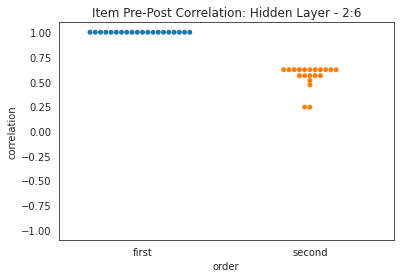

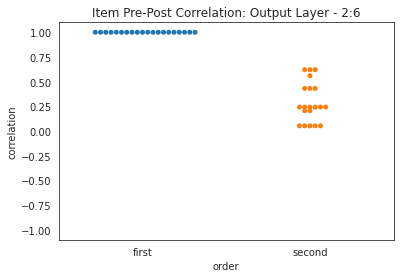

In [43]:


def plot_pre_post_correlation(data, layer):
    data=data.reset_index()


    ## get first and last epochs
    first_epoch = data['|Epoch'].min()
    last_epoch = data['|Epoch'].max()

    ## Reorganize the data frame
    data = data[data['|Epoch'].isin([first_epoch, last_epoch])]
    data = data.drop(columns = ['$CurrentTask', 'high1', 'high2', 'low1', 'low2'])
    data = data.melt(var_name='Trial', value_name='actM', value_vars=['med1', 'med2'], id_vars=['|Run', '|Epoch', '$CurrentTest', 'key'] )
    data = data.pivot(index=['|Run', '$CurrentTest', 'key', 'Trial'], columns = '|Epoch', values='actM').reset_index()
    data = data.sort_values(['|Run', '$CurrentTest', 'Trial', 'key'])

    ## Get the correlation values:
    data.head(30)
    df_pre_post_corr = data.groupby(['|Run', '$CurrentTest','Trial']).corr().reset_index()

    ## Reorganize the dataframe again:
    df_pre_post_corr = df_pre_post_corr.rename(columns={'|Epoch':'pre_post1'})
    df_pre_post_corr = df_pre_post_corr.melt(id_vars = ['|Run', '$CurrentTest', 'Trial', 'pre_post1'], var_name='pre_post2', value_vars=[first_epoch, last_epoch], value_name='correlation')

    ## We only care about correlation pre vs post:
    df_pre_post_corr = df_pre_post_corr[(df_pre_post_corr['pre_post1'] == first_epoch) & (df_pre_post_corr['pre_post2'] == last_epoch)]

    ## get the order (which trial came first or second)
    df_pre_post_corr = pd.merge(data_train_order, df_pre_post_corr, left_on = ['|Run', '$TrialName'], right_on = ['|Run', 'Trial'])

    ## add the trial type
    df_pre_post_corr['overlap'] = parameter_values['overlap']['overlapType']

    sns.swarmplot(x = 'order', y = 'correlation', data = df_pre_post_corr)
    plt.ylim(-1.1,1.1)
    
    
    title = 'Item Pre-Post Correlation: ' + layer.capitalize() + ' Layer - ' + parameter_values['overlap']['overlapType'].replace('/',':')
    plt.title(title)

    
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    
    df_pre_post_corr['layer'] = layer
    return df_pre_post_corr


df_pre_post_corr_hidd = plot_pre_post_correlation(hiddenData, 'hidden')
df_pre_post_corr_out = plot_pre_post_correlation(outputData, 'output')

df_pre_post_corr = pd.concat([df_pre_post_corr_hidd,df_pre_post_corr_out])


### Output Layer: Is the low/med/high within pair correlation in the right order in the color layer?

<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_color_layer?'></a>

In [44]:
outputData

$TrialName                                                        high1  \
|Run |Epoch $CurrentTask    $CurrentTest key                              
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>    0.0   
                                         #OutActM[2:0,1]            0.0   
                                         #OutActM[2:0,2]            0.0   
                                         #OutActM[2:0,3]            0.0   
                                         #OutActM[2:0,4]            0.0   
...                                                                 ...   
19    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]           0.0   
                                         #OutActM[2:0,46]           0.0   
                                         #OutActM[2:0,47]           0.0   
                                         #OutActM[2:0,48]           0.0   
                                         #OutActM[2:0,49]           0.0   

$TrialName                                                        high2  low1  \
|Run |Epoch $CurrentTask    $CurrentTest key                                    
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>    0.0   0.0   
                                         #OutActM[2:0,1]            0.0   0.0   
                                         #OutActM[2:0,2]            0.0   0.0   
                                         #OutActM[2:0,3]            0.0   0.0   
                                         #OutActM[2:0,4]            0.0   0.0   
...                                                                 ...   ...   
19    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]           0.0   0.0   
                                         #OutActM[2:0,46]           0.0   0.0   
                                         #OutActM[2:0,47]           0.0   0.0   
                                         #OutActM[2:0,48]           0.0   0.0   
                                         #OutActM[2:0,49]           0.0   0.0   

$TrialName                                                        low2  \
|Run |Epoch $CurrentTask    $CurrentTest key                             
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>   0.0   
                                         #OutActM[2:0,1]           0.0   
                                         #OutActM[2:0,2]           0.0   
                                         #OutActM[2:0,3]           0.0   
                                         #OutActM[2:0,4]           0.0   
...                                                                ...   
19    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]          0.0   
                                         #OutActM[2:0,46]          0.0   
                                         #OutActM[2:0,47]          0.0   
                                         #OutActM[2:0,48]          0.0   
                                         #OutActM[2:0,49]          0.0   

$TrialName                                                                med1  \
|Run |Epoch $CurrentTask    $CurrentTest key                                     
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>  1.401000e-45   
                                         #OutActM[2:0,1]          1.401000e-45   
                                         #OutActM[2:0,2]          1.401000e-45   
                                         #OutActM[2:0,3]          1.401000e-45   
                                         #OutActM[2:0,4]          1.401000e-45   
...                                                                        ...   
19    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]         1.401000e-45   
                                         #OutActM[2:0,46]         1.401000e-45   
                                         #OutActM[2:0,47]         1.401000e-45   
                                         #OutActM[2:0,48]         1.401000e-45   
                       


# MDS
<a id='MDS'></a>

In [45]:
data_test

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0.0,0.0,0.9997,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.0,0.0,0.9977,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,-1,TaskColorWOOsc,TestColorAll,2,low1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0,-1,TaskColorWOOsc,TestColorAll,3,low2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0,-1,TaskColorWOOsc,TestColorAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,19,19,TaskColorRecall,TestFaceAll,3,low2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4916,19,19,TaskColorRecall,TestColorAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4917,19,19,TaskColorRecall,TestFaceAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4918,19,19,TaskColorRecall,TestColorAll,5,high2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [46]:

def find_order_data_test(row, data_train_order) :

    curr_stim = row['$TrialName']
    curr_run = row['|Run']

    order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   

    order = order.iloc[0]
    return order


def prepare_MDS_data(data) :
    
    run = 0
    
    col = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']
    col.extend(filter_HiddM)

#    color_task = data['$CurrentTask'] == 'TaskColorRecall'
    color_test = data['$CurrentTest'] == 'TestColorAll'



    select_data = data[color_test][col]
    select_data= select_data[select_data['$TrialName'].isin(['med1', 'med2'])]
    select_data['order'] = select_data.apply(lambda row : find_order_data_test(row, data_train_order), axis = 1)

    

    
    all_data = np.empty([0, 50])
    all_runs = np.empty([0])
    all_names = np.empty([0])
    all_trialnames = np.empty([0])
    
    for run in range(nruns + 1):

        run_data = select_data[select_data['|Run'] == run]
        pre = run_data['|Epoch'] == run_data['|Epoch'].min()
        post = run_data['|Epoch'] == run_data['|Epoch'].max()
        first = run_data['order'] == 'first'
        second = run_data['order'] == 'second'
        
        first_pre = run_data[first & pre][filter_HiddM].to_numpy()
        first_post = run_data[first & post][filter_HiddM].to_numpy()

        second_pre = run_data[second & pre][filter_HiddM].to_numpy()
        second_post = run_data[second & post][filter_HiddM].to_numpy()

        run_array = np.array([first_pre[0], first_post[0], second_pre[0], second_post[0]])


        
        all_data = np.append(all_data, run_array,0)
    
        all_runs = np.append(all_runs, np.repeat(np.round(run), 4))
        all_names = np.append(all_names, ['first_pre','first_post', 'second_pre', 'second_post'])
        
        all_trialnames = np.append(all_trialnames, 
                                   np.concatenate([np.tile(run_data[first & pre]['$TrialName'].iloc[0],2),
                                   np.tile(run_data[second & pre]['$TrialName'].iloc[0],2)]))
    
        MDS_data = {'data' : all_data, 'runs': all_runs, 'names': all_names, 'trial_names': all_trialnames}

    if MDS_data['data'].shape[0] != MDS_data['runs'].shape[0] or MDS_data['data'].shape[0] != MDS_data['names'].shape[0]:
        raise ValueError
        print('Something wrong with the dimensions here')
    return select_data, MDS_data

select_data, MDS_data = prepare_MDS_data(data_test)



running MDS analysis


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

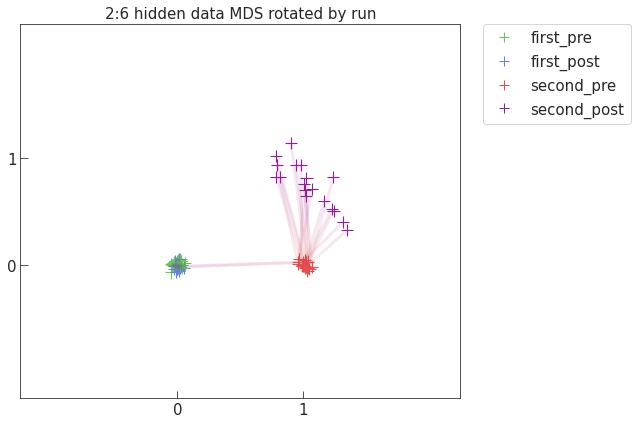

In [47]:
print("running MDS analysis", flush=True)
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.collections as mcoll

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 4. * np.pi, 100)
    y = np.sin(x)
    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap='hsv')
    plt.colorbar(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(ax,
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def MDS_plot_procrustes(MDS_data, run, distance_func="euclidean") :
    def euclidean(x,y):
        return np.linalg.norm(x-y)
    def pearsoncorr(x,y):
        return stats.stats.pearsonr(x, y)[0]
    if distance_func == "euclidean":
        distance_metric = euclidean
    else:
        distance_metric = pearsoncorr
        
    def show_activation(data):
        plt.clf()
        plt.imshow(data, cmap='plasma')
        plt.show()
    
    def show_distance_matrices_activation_embds(data, embds):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        run_distances = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances[i, j] = distance_metric(data[i],data[j])
        ax0.imshow(run_distances, cmap='plasma')
        # We want to show all ticks...
        ax0.set_xticks(np.arange(4))
        ax0.set_yticks(np.arange(4))
        ax0.set_xticklabels(labels)
        ax0.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax0.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax0.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")

        run_distances_copy = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances_copy[i, j] = distance_metric(embds[i],embds[j])
        
        ax1.imshow(run_distances_copy, cmap='plasma')
        # We want to show all ticks...
        ax1.set_xticks(np.arange(4))
        ax1.set_yticks(np.arange(4))
        ax1.set_xticklabels(labels)
        ax1.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax1.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")
                
        plt.show()
        
    def show_scatter_pre_post_transform(pre, post, names):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        ax0.scatter(pre[:,0], pre[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        ax1.scatter(post[:,0], post[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.show()
    
    def get_polar_angle(x, y):
        return np.arctan2(y, x) 
    
    def procrustes(data1, scale_pre_embd_dist):
        mtx1 = data1

        if mtx1.ndim != 2:
            raise ValueError("Input matrices must be two-dimensional")
        if mtx1.size == 0:
            raise ValueError("Input matrices must be >0 rows and >0 cols")
            
        # translate all the data to the origin
        
        translate = mtx1[[0]]
        temp = mtx1 - mtx1[[0]]
        theta = get_polar_angle(temp[1, 0], temp[1, 1])
        rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                    [np.sin(-theta), np.cos(-theta)]])
        scale = np.linalg.norm(temp[1]) / (-0.2 * scale_pre_embd_dist  + 1.4)
        
        
        return translate, rotation_matrix, scale
    color_dict = {'first_pre': [.4, .8, .3], 'first_post': [.4, .5, .9],
                  'second_pre': [.9, .3, .3], 'second_post': [.6, .1, .6],
                  'mean_first': [.4, .65, .6], 'mean_second': [.75, .2, .45]
                 }
        

    data = MDS_data['data']
    names = MDS_data['names']
    labels = ['first_pre', 'first_post', 'second_pre', 'second_post']
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(9, 6))
    embedding = MDS(n_components = 2)
    #print(data.sh)

    # Flip embeddings across midline if trial starts with med2
    roll_units = {0: 0, 1: 0, 2:-1, 3:-1, 4: -2, 5:-2}
    if parameter_values['overlap']['numOverlapUnits'] % 2 == 1:
        data = np.hstack((data, np.zeros((data.shape[0], 1))))
    data = np.roll(data,roll_units[parameter_values['overlap']['numOverlapUnits']], axis=-1)
    transformed_data = []
    for run in range(nruns+1):
        
        if MDS_data["trial_names"][4 * run] == "med2":
            
            _ = np.fliplr(data[4 * run:4 * run+4])
            
        else:
            _ = data[4 * run:4 * run+4]
            
        #print(_)
        transformed_data.append(_)
    data = np.concatenate(transformed_data, axis=0)
    
    X_transformed = embedding.fit_transform(data)
    translate = X_transformed[[0]]
    X_transformed -= translate
    theta = get_polar_angle(X_transformed[2, 0], X_transformed[2, 1])
    rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                [np.sin(-theta), np.cos(-theta)]])

    scale = np.linalg.norm(X_transformed[2]) / (-0.2 * parameter_values['overlap']['numOverlapUnits']  + 1.4)
    X_transformed =1/scale* (rotation_matrix@X_transformed.T).T + np.random.randn(*X_transformed.shape)*0.03
    
    # Flip across y-axis if most second-post points are below y-axis
    if np.mean(X_transformed[3::4, 1] > 0) < 0.5:
        X_transformed *= np.array([[1, -1]])
            
    scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], 
                         c = [color_dict[name] for name in names], 
            alpha = 1.0, marker='+', s=150,zorder=2, linewidths=1.10)
    
    
    for run in range(nruns+1):
        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['first_pre'], color_dict['first_post']], N=20)
        x = np.linspace(X_transformed[4*run+0,0],X_transformed[4*run+1,0],100)
        y = np.linspace(X_transformed[4*run+0,1],X_transformed[4*run+1,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)

        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['second_pre'], color_dict['second_post']], N=20)
        x = np.linspace(X_transformed[4*run+2,0],X_transformed[4*run+3,0],100)
        y = np.linspace(X_transformed[4*run+2,1],X_transformed[4*run+3,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)
        
    #plt.axis('square')
    
    legend_elements = [
                   Line2D([0], [0], marker='+', color=color_dict['first_pre'], label='first_pre',
                          markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['first_post'], label='first_post',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_pre'], label='second_pre',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_post'], label='second_post',
                                      markersize=10, lw = 0)
    ]

    ax.legend(handles = legend_elements, bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0., fontsize=15)
    title = parameter_values['overlap']['overlapType'].replace('/',':') + ' hidden data MDS rotated by run'
    ax.set_title(title)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    
    
    plt.xlim(-1.25, 2.25)
    plt.ylim(-1.25, 2.25)
    #ax.grid(True)
    #ax.xaxis.set_tick_params(width=5, length=15)
    #ax.yaxis.set_tick_params(width=5, length=15)
    
    #plt.setp(ax.xaxis.get_major_ticks(), visible=True, size=100)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.tick_params(length=7.5, bottom=True, left=True, direction="in")
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    plt.savefig(eps_dir + title + '.eps')

    plt.show()

    
# MDS_plot(MDS_data, 0)
MDS_plot_procrustes(MDS_data, 'all')



<Figure size 432x288 with 0 Axes>

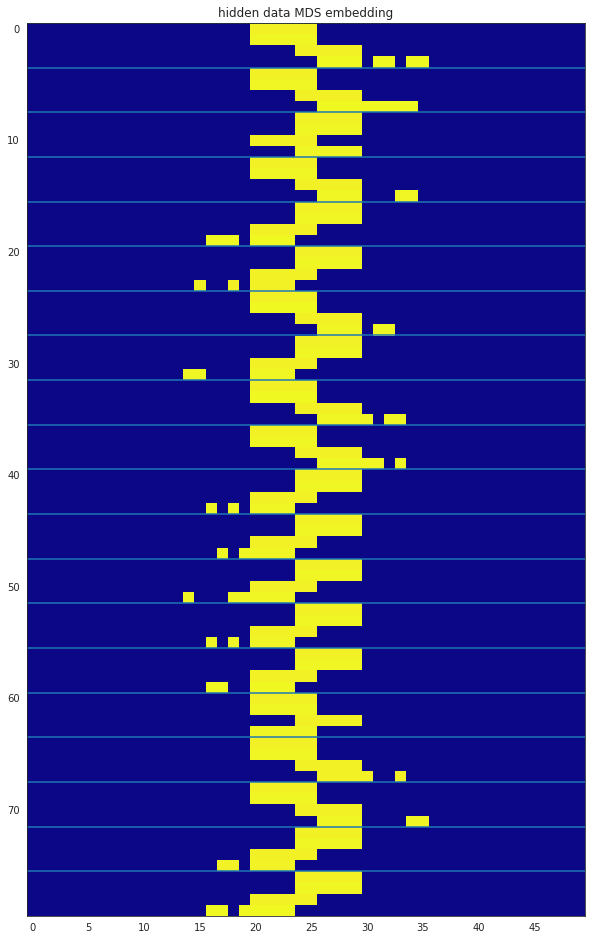

In [48]:
plt.clf()
fig, ax = plt.subplots(figsize = (10,20))
_ = np.roll(MDS_data["data"], -1, axis=-1)
plt.xticks(np.arange(0, 50, 5))
im = ax.imshow(np.flip(_,axis=-1), cmap='plasma')
[plt.axhline(i*4-0.5) for i in range(nruns+1)]
title = 'hidden data MDS embedding'
plt.title(title)
plt.savefig(results_fig_dir + title + '.png')
plt.show()

## Difference score
<a id='within-pair_correlation_minus_across-pair_correlation._Done_in_the_hidden_layer._'></a>
#### within-pair correlation minus across-pair correlation. Done in the hidden layer. 
as in Favila et al 2016, we expect that by the end, the high competition group should have a positive score indicating that the representations are more similar to each other than to other items. Medium overlap should have a negative score, and low overlap should be near zero. 

In [49]:
print('calculating difference score')

calculating difference score


In [50]:
if medium_only_analysis == False :

    def diff_score(data, layer, analyses_df) :
        title = 'Correlation Difference Score in ' + layer + ' Layer'
        try:
            plt.clf()
            df_diff_score = pd.DataFrame(columns = ['run', 'epoch', 'pair', 'diff_score'])

            #Difference score 
            names = data['firstItem'].unique()
            names = [n[:-1] for n in names]
            names = list(set(names))
            epochs_to_compare = [epoch_end_initial, max_final_epoch]
            for run in range(data_train['|Run'].max()) :
                #for loop run
                for epoch in epochs_to_compare :

                    for cat_overlap in names : 

                        first_item = cat_overlap + '1'
                        second_item = cat_overlap + '2'
                        pair = [first_item, second_item]

                        is_run = data['|Run'] == run
                        is_last_epoch  = data['|Epoch'] == epoch
                        is_first_trial = data['firstItem'] == first_item
                        is_second_trial = data['firstItem'] == second_item


                        #first pairmate, all correlations
                        first_item_all = data[is_first_trial & is_run & is_last_epoch]

                        #within pair correlation
                        within = first_item_all[first_item_all['secondItem'] == second_item]
                        within = within.iloc[0]['correlation']

                        #second pairmate, all correlations
                        second_item_all = data[is_second_trial & is_run & is_last_epoch]

                        #first pairmate, non pair correlations
                        other1 = first_item_all[-first_item_all['secondItem'].isin(pair)]
                        #second pairmate, non pair correlations
                        other2 = second_item_all[-second_item_all['secondItem'].isin(pair)]

                        #put them together and take mean
                        other = other1.append(other2)
                        other_corr_mean = other['correlation'].mean()

                        #calculate difference score
                        difference_score = within - other_corr_mean


                        #add to dataframe
                        temp = [run, epoch, cat_overlap, difference_score]
                        temp_series = pd.Series(temp, index =df_diff_score.columns)
                        df_diff_score = df_diff_score.append(temp_series, ignore_index =True)

            df_diff_score

            sns.barplot(x = 'pair', y = 'diff_score', hue='epoch', data = df_diff_score)
            plt.ylim(-1.5,1.5)

            plt.title(title)
            plt.tight_layout()
            plt.savefig(results_fig_dir + title + '.png')
            if from_cmdLine != 'cmd' :
                plt.show()

            analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
            return df_diff_score, analyses_df
        except:
            traceback.print_exc()
            analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
            return "error", analyses_df


    plt.clf()
    df_diff_score_hidden, analyses_df = diff_score(hidden_corr_long, 'Hidden', analyses_df)
    plt.clf()
    df_diff_score_color, analyses_df = diff_score(output_corr_long, 'Color', analyses_df)

# CENTER OF MASS 
<a id='CENTER_OF_MASS'></a>

In [51]:
print('analysis for center of mass')

analysis for center of mass


In [52]:
def calc_center_of_mass(act_array):
    unit_num = np.arange(1,51)

    weighted = unit_num * act_array
    weighted_sum = weighted.sum()
    mass_sum = act_array.sum() + 1e-30
    center_temp = weighted_sum / mass_sum
    #print("act_array", mass_sum)
    return center_temp

In [53]:
def calc_coa_true() :
    numTotalUnits = parameter_values['overlap']['numTotalUnits']
    numOverlapUnits = parameter_values['overlap']['numOverlapUnits'] 

    print("Warning: Assuming med2 color representation starts at index 25")
    unique = numTotalUnits - numOverlapUnits
    true_val_dict = {}
    true_val_dict['med1'] = (25 + 1 - 2 * unique + 25 + numTotalUnits)/2
    true_val_dict['med2'] = (25 + 1 + 25 + numTotalUnits)/2
    
    return true_val_dict

true_val_dict = calc_coa_true()

In [54]:


def find_center_of_mass(data, epoch, trial, run, layer) :
#     center_of_mass = np.empty(0)
#     for run in range(data_train['|Run'].max()):
    
    if_curr_run = data_test['|Run'] == run
    if_baseline_epoch = data_test['|Epoch'] == epoch
    if_trial = data_test['$TrialName'] == trial

    if layer == 'color':
        col_str = '#OutActM[' 
    elif layer == 'hidden' :
        col_str = '#HiddenActM['
        

    layer_col = [col for col in data.columns if col.startswith(col_str)]
    
    curr = data_test[if_curr_run & if_baseline_epoch & if_trial][layer_col].reset_index(drop = True)

    curr_np = curr.iloc[[0]].to_numpy()
    
    center_temp = calc_center_of_mass(curr_np)
    return center_temp


In [55]:

def get_center_mass_df(data, layer) :
    center_of_mass_df = pd.DataFrame(columns = ['run', 'time', 'type','stim', 'layer', 'c_o_m'])

    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            if time == 'pre' :
                epoch = epoch_end_initial

            elif time == 'post' :
                epoch = max_final_epoch

                
            for item in ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']:
                c_o_a = find_center_of_mass(data, epoch, item, run, layer = layer)
                temp = [run, time, 'raw', item, layer, c_o_a]
                temp_series = pd.Series(temp, index = center_of_mass_df.columns)
                center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)


    return center_of_mass_df


In [56]:

def get_center_mass_df_all_epochs(data, layer) :
    center_of_mass_df = pd.DataFrame(columns = ['run', 'time', 'type','stim', 'layer', 'c_o_m'])

    for run in range(data_train['|Run'].max()) :
        for epoch in range(-1, max_final_epoch) :
            time = epoch


                
            for item in ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']:
                c_o_a = find_center_of_mass(data, epoch, item, run, layer = layer)
                temp = [run, time, 'raw', item, layer, c_o_a]
                temp_series = pd.Series(temp, index = center_of_mass_df.columns)
                center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)

    return center_of_mass_df


In [57]:

is_color_test = data_test['$CurrentTest'] == 'TestColorAll'
is_color_recall = data_test['$CurrentTask'] == 'TaskColorRecall'

curr_data_test = data_test[is_color_test & is_color_recall]



color_center_of_mass_df = get_center_mass_df(curr_data_test, 'color')
hidden_center_of_mass_df = get_center_mass_df(curr_data_test, 'hidden')


color_center_of_mass_all_epochs_df = get_center_mass_df_all_epochs(curr_data_test, 'color') 

In [58]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m
0,0,-1,raw,low1,color,0.000000
1,0,-1,raw,low2,color,0.000000
2,0,-1,raw,med1,color,24.504348
3,0,-1,raw,med2,color,28.495514
4,0,-1,raw,high1,color,0.000000
...,...,...,...,...,...,...
2275,18,18,raw,low2,color,0.000000
2276,18,18,raw,med1,color,24.499364
2277,18,18,raw,med2,color,33.333480
2278,18,18,raw,high1,color,0.000000


### compare to true center of mass

In [59]:
def flip_error(row, true_val_dict):
    
    curr_stim = row['stim']

    if curr_stim[-1] == '1' :
        other_stim_n = '2'
    elif curr_stim[-1] == '2' :
        other_stim_n = '1'
        
    other_stim = curr_stim[:-1] + other_stim_n
    
    if (other_stim in true_val_dict) and (curr_stim in true_val_dict):
        dist_size = true_val_dict[other_stim] - true_val_dict[curr_stim]

        ### NOTE: THIS ONLY WORKS RIGHT NOW DIST SIZE IS LESS THAN 180
        ### NOTE: THIS ONLY WORKS RIGHT NOW FOR MED UNITS
        if dist_size < 0 :
            rev_error = -1 * row['raw_error']
        else :
            rev_error = row['raw_error']


        return rev_error 
    else:
        return 0


In [60]:
color_center_of_mass_df

,run,time,type,stim,layer,c_o_m
0,0,pre,raw,low1,color,0.000000
1,0,pre,raw,low2,color,0.000000
2,0,pre,raw,med1,color,24.504348
3,0,pre,raw,med2,color,28.495514
4,0,pre,raw,high1,color,0.000000
...,...,...,...,...,...,...
223,18,post,raw,low2,color,0.000000
224,18,post,raw,med1,color,24.499364
225,18,post,raw,med2,color,33.333480
226,18,post,raw,high1,color,0.000000


In [61]:
def calc_error(c_o_a_df_color, true_val_dict) :
    
    c_o_a_df_color = c_o_a_df_color.dropna()

    c_o_a_df_color['true_c_o_m'] = c_o_a_df_color['stim'].map(true_val_dict)
    

    c_o_a_df_color['raw_error'] = round(c_o_a_df_color['c_o_m'] - c_o_a_df_color['true_c_o_m'], 5)
    
    c_o_a_df_color['rev_error'] = c_o_a_df_color.apply(lambda row: flip_error(row, true_val_dict), axis=1)
    

    return c_o_a_df_color
    
    ## This is where we'd run 

In [62]:
color_center_of_mass_all_epochs_df = calc_error(color_center_of_mass_all_epochs_df, true_val_dict)
color_center_of_mass_df = calc_error(color_center_of_mass_df, true_val_dict) 

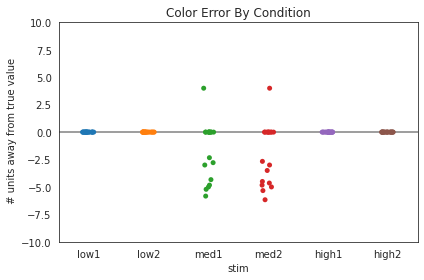

In [63]:
def plot_error(data) :
    plt.clf()
    is_post = data['time'] == 'post'

    subset_data = data[is_post ]
    sns.stripplot(x='stim', y = 'rev_error',data = subset_data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Condition'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error(color_center_of_mass_df)
    

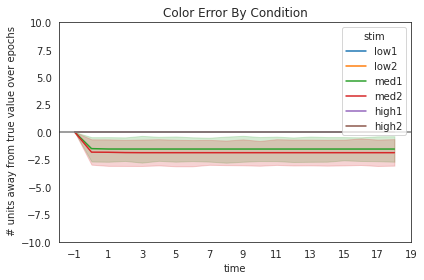

In [64]:
def plot_error_over_time(data) :
    

    plt.clf()
    sns.lineplot(x='time', y = 'rev_error', hue = 'stim', data = data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Condition'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error_over_time(color_center_of_mass_all_epochs_df)
    

In [65]:

## Get the initial order: 

data_train_order = data_train.copy()
data_train_order= data_train_order[['|Run','|Epoch', '$CurrentTask', '|Trial', '$TrialName']]

if task_run !='just_face':
    data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskColorRecall']
else:
    data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskFaceRecall']


data_train_order = data_train_order[data_train_order['$TrialName'].isin(['med1','med2'])]

data_train_order = data_train_order[data_train_order['|Epoch'] == min(data_train_order['|Epoch']) ]
print(data_train_order)

order_map_dict = {0: 'first', 1:'second'}
data_train_order['order'] = data_train_order['|Trial'].map(order_map_dict)
data_train_order = data_train_order[['|Run', '$TrialName', 'order']]


      |Run  |Epoch     $CurrentTask  |Trial $TrialName
0        0       0  TaskColorRecall       0       med2
1        0       0  TaskColorRecall       1       med1
120      1       0  TaskColorRecall       0       med2
121      1       0  TaskColorRecall       1       med1
240      2       0  TaskColorRecall       0       med1
241      2       0  TaskColorRecall       1       med2
360      3       0  TaskColorRecall       0       med2
361      3       0  TaskColorRecall       1       med1
480      4       0  TaskColorRecall       0       med1
481      4       0  TaskColorRecall       1       med2
600      5       0  TaskColorRecall       0       med1
601      5       0  TaskColorRecall       1       med2
720      6       0  TaskColorRecall       0       med2
721      6       0  TaskColorRecall       1       med1
840      7       0  TaskColorRecall       0       med1
841      7       0  TaskColorRecall       1       med2
960      8       0  TaskColorRecall       0       med2
961      8

In [66]:
# color_center_of_mass_df[(color_center_of_mass_df['stim'].isin(['med1','med2'])) & (color_center_of_mass_df['run']==1)]

def find_order(row, data_train_order) :
    curr_stim = row['stim']
    curr_run = row['run']
    if curr_stim in np.unique(data_train_order['$TrialName']):
        order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   
        order = order.iloc[0]
        return order
    else:
        return None

color_center_of_mass_df['order'] = color_center_of_mass_df.apply(lambda row : find_order(row, data_train_order), axis = 1)
color_center_of_mass_all_epochs_df['order'] = color_center_of_mass_all_epochs_df.apply(lambda row : find_order(row, data_train_order), axis = 1)




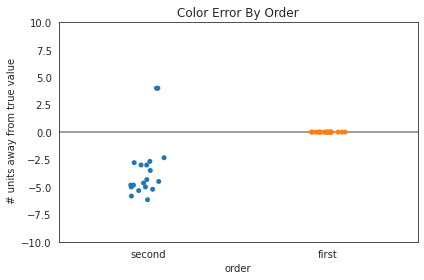

In [67]:
def plot_error_order(data) :
    plt.clf()
    is_post = data['time'] == 'post'

    subset_data = data[is_post]

    sns.stripplot(x='order', y = 'rev_error', data = subset_data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Order'
    plt.title(title)
    
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()


plot_error_order(color_center_of_mass_df)

In [68]:
color_center_of_mass_all_epochs_df


,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504348,24.5,0.00435,0.00435,second
3,0,-1,raw,med2,color,28.495514,28.5,-0.00449,0.00449,first
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
2275,18,18,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2276,18,18,raw,med1,color,24.499364,24.5,-0.00064,-0.00064,first
2277,18,18,raw,med2,color,33.333480,28.5,4.83348,-4.83348,second
2278,18,18,raw,high1,color,0.000000,NaN,NaN,0.00000,None


In [69]:
color_center_of_mass_all_epochs_df
color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['run'] == 3].head(10)

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
360,3,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
361,3,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
362,3,-1,raw,med1,color,24.504384,24.5,0.00438,0.00438,second
363,3,-1,raw,med2,color,28.495380,28.5,-0.00462,0.00462,first
364,3,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
365,3,-1,raw,high2,color,0.000000,NaN,NaN,0.00000,None
366,3,0,raw,low1,color,0.000000,NaN,NaN,0.00000,None
367,3,0,raw,low2,color,0.000000,NaN,NaN,0.00000,None
368,3,0,raw,med1,color,20.202428,24.5,-4.29757,-4.29757,second
369,3,0,raw,med2,color,28.497643,28.5,-0.00236,0.00236,first


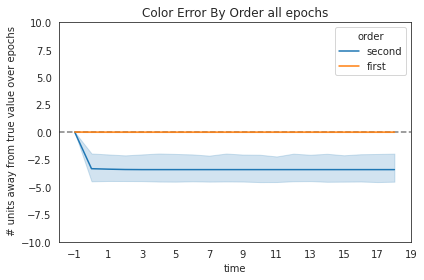

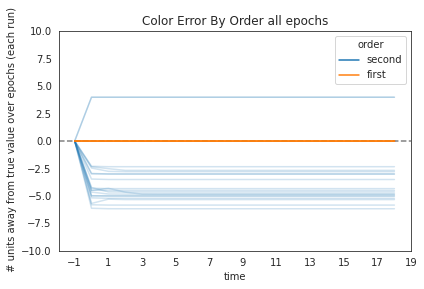

In [70]:
def plot_error_over_time_with_order(data) :
    
    plt.clf()
    

#     data = data[data['run'] == 3]
    plt.axhline(0, ls = '--', color = 'gray')

    sns.lineplot(x='time', y = 'rev_error', hue = 'order', data = data)
    title = 'Color Error By Order all epochs'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    

    ### each epoch separately 
    plt.clf()
    plt.axhline(0, ls = '--', color = 'gray')

    sns.lineplot(x='time', y = 'rev_error', hue = 'order', units = 'run', estimator = None, alpha = .2, data = data)
    title = 'Color Error By Order all epochs'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs (each run)')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error_over_time_with_order(color_center_of_mass_all_epochs_df)
    


#### Plot distance center of mass

In [71]:
def calc_c_o_a_distance(center_of_mass_df, layer) :
    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            pair = 'med' #this is only for med right now
            is_run = center_of_mass_df['run']==run
            is_time = center_of_mass_df['time']== time

            item1 = pair + '1'
            item2 = pair + '2'

            val2 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item2)][['c_o_m']].to_numpy()
            val1 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item1)][['c_o_m']].to_numpy()

 
            diff = val2 - val1
            diff = diff[0][0]
            true_coa = true_val_dict['med2'] - true_val_dict['med1']
            name = pair + '_diff'
            temp = [run, time, 'diff', name, layer, diff, true_coa, np.nan, np.nan, np.nan]

            temp_series = pd.Series(temp, index = center_of_mass_df.columns)

            center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)# for item in ['post_low1', 'post_low2', 'post_med1', 'post_med2' ,'post_high1', 'post_high2'] :

    return center_of_mass_df


In [72]:
# same thing, but over each epoch
def calc_c_o_a_distance_epochs(center_of_mass_df, layer) :
    for run in range(data_train['|Run'].max()) :
        for epoch in range(-1, max_final_epoch) :
            time = epoch
            pair = 'med' #this is only for med right now
            is_run = center_of_mass_df['run']==run
            is_time = center_of_mass_df['time']== time
            item1 = pair + '1'
            item2 = pair + '2'

            val2 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item2)][['c_o_m']].to_numpy()
            val1 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item1)][['c_o_m']].to_numpy()

            
            diff = val2 - val1
            diff = diff[0][0]
            true_coa = true_val_dict['med2'] - true_val_dict['med1']
            name = pair + '_diff'
            temp = [run, time, 'diff', name, layer, diff, true_coa, np.nan, np.nan, np.nan]

            temp_series = pd.Series(temp, index = center_of_mass_df.columns)

            center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)# for item in ['post_low1', 'post_low2', 'post_med1', 'post_med2' ,'post_high1', 'post_high2'] :

    return center_of_mass_df



In [73]:
def plot_center_of_mass_dist_epochs(center_of_mass_df, layer) :
    ## Use try except block to not break the script if there's an error
    ## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
    title = 'Distance Between Center of Masses Across Epochs: ' + layer 
    

    plt.clf()

    ax = sns.lineplot(x = "time", y="c_o_m", units="run", estimator=None, data=center_of_mass_df, alpha = .2, legend = False)

    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.ylim(-1,12)
    plt.ylabel('units apart')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))

    correct_val = true_val_dict['med2'] - true_val_dict['med1']
    plt.axhline(y=correct_val, linestyle='--',color = 'k')
    
    plt.title(title)
    
    
    
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()

    print('this is assuming just medium overlap condition:')
    units_apart = center_of_mass_df.dropna()
    units_apart[units_apart['time'] == 'post']


In [74]:
color_center_of_mass_df = calc_c_o_a_distance(color_center_of_mass_df, 'layer')
color_distance_df = color_center_of_mass_df[color_center_of_mass_df['stim'].isin(['med_diff'])]

color_center_of_mass_all_epochs_df = calc_c_o_a_distance_epochs(color_center_of_mass_all_epochs_df, 'layer')
color_distance_epochs_df = color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['stim'].isin(['med_diff'])]


In [75]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504348,24.5,0.00435,0.00435,second
3,0,-1,raw,med2,color,28.495514,28.5,-0.00449,0.00449,first
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
2655,18,14,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2656,18,15,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2657,18,16,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2658,18,17,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN


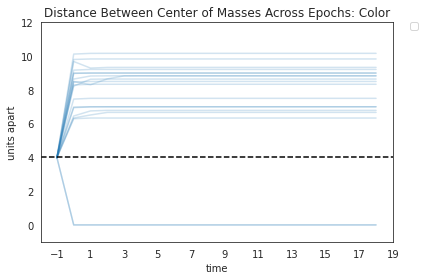

this is assuming just medium overlap condition:


In [76]:
plot_center_of_mass_dist_epochs(color_distance_epochs_df, 'Color')


In [77]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504348,24.5,0.00435,0.00435,second
3,0,-1,raw,med2,color,28.495514,28.5,-0.00449,0.00449,first
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
2655,18,14,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2656,18,15,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2657,18,16,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN
2658,18,17,diff,med_diff,layer,8.834116,4.0,NaN,NaN,NaN


    epoch  repulsion  repulsion_percent overlap
0      -1          0           0.000000     2/6
1       0         17          89.473684     2/6
2       1         17          89.473684     2/6
3       2         17          89.473684     2/6
4       3         17          89.473684     2/6
5       4         17          89.473684     2/6
6       5         17          89.473684     2/6
7       6         17          89.473684     2/6
8       7         17          89.473684     2/6
9       8         17          89.473684     2/6
10      9         17          89.473684     2/6
11     10         17          89.473684     2/6
12     11         17          89.473684     2/6
13     12         17          89.473684     2/6
14     13         17          89.473684     2/6
15     14         17          89.473684     2/6
16     15         17          89.473684     2/6
17     16         17          89.473684     2/6
18     17         17          89.473684     2/6
19     18         17          89.473684 

<ipython-input-78-3d8285037f55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repulsion_all['repulsion'] = np.where(np.round(repulsion_all['c_o_m'],3) > np.round(repulsion_all['true_c_o_m'],3), 1, 0)


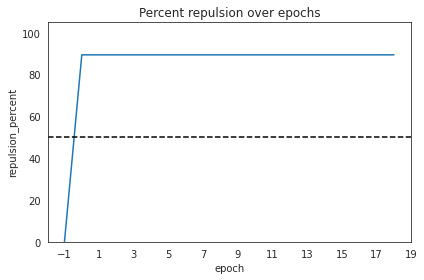

In [78]:
def plot_percent_repulsion_over_epochs(color_center_of_mass_all_epochs_df) :
    
    plt.clf()
    repulsion_all = color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['stim'] == 'med_diff']
    repulsion_all['repulsion'] = np.where(np.round(repulsion_all['c_o_m'],3) > np.round(repulsion_all['true_c_o_m'],3), 1, 0)
    repulsion_count_each_run = pd.DataFrame(repulsion_all.groupby('time')['repulsion'].sum()).reset_index()
    repulsion_count_each_run
    repulsion_count_each_run['repulsion_percent'] = repulsion_count_each_run['repulsion'].div(nruns) * 100
    repulsion_count_each_run =repulsion_count_each_run.rename(columns={"time": "epoch"})
    repulsion_count_each_run['overlap'] = parameter_values['overlap']['overlapType']
    
    sns.lineplot(x= 'epoch', y = 'repulsion_percent', data = repulsion_count_each_run)
    plt.axhline(y = 50, linestyle = '--', color= 'k')
    plt.ylim(0,105)
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))

    title = 'Percent repulsion over epochs'
    plt.title(title)
    print(repulsion_count_each_run)
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
        
    return repulsion_count_each_run, repulsion_all
    
repulsion_count_each_run, repulsion_all = plot_percent_repulsion_over_epochs(color_center_of_mass_all_epochs_df)
    
#     sns.lineplot(x= 'time', y = 'repulsion_percent', data = r)

## Scatter plot hidden center of mass repulsion vs. output center of mass repulsion
<a id='Scatter_plot_hidden_center_of_mass_repulsion_vs_output_center_of_mass_repulsion'></a>

In [79]:
def join_center_of_mass_DFs(color_c_m_DF, hidden_c_m_DF) :
    
    color_c_m_DF['layer'] = 'color'
    hidden_c_m_DF['layer'] = 'hidden'

    new_df = color_c_m_DF.append(hidden_c_m_DF)
    
    new_df['overlap'] = parameter_values['overlap']['overlapType']
    return new_df

center_of_mass_df = join_center_of_mass_DFs(color_center_of_mass_df,hidden_center_of_mass_df)


In [80]:
category_palette

{'low': (0.7, 0.4, 0.7), 'med': (0.3, 0.4, 0.7), 'high': (0.5, 0.8, 0.5)}

layer_color  c_o_m_color  true_c_o_m_color  \
run time type stim                                                  
0   post raw  low1           color     0.000000               NaN   
              low2           color     0.000000               NaN   
              med1           color    19.285746              24.5   
              med2           color    28.500856              28.5   
              high1          color     0.000000               NaN   
...                            ...          ...               ...   
14  post diff med_diff       color     6.667822               4.0   
15  post diff med_diff       color    -0.000004               4.0   
16  post diff med_diff       color     9.833767               4.0   
17  post diff med_diff       color     8.834306               4.0   
18  post diff med_diff       color     8.834116               4.0   

                        raw_error_color  rev_error_color   order layer_hidden  \
run time type stim                                                              
0   post raw  low1                  NaN        -0.117895    None          NaN   
              low2                  NaN        -0.111380    None          NaN   
              med1             -5.21425        -5.093034  second       hidden   
              med2              0.00086         0.140239   first       hidden   
              high1                 NaN        -0.111181    None          NaN   
...                                 ...              ...     ...          ...   
14  post diff med_diff              NaN              NaN     NaN          NaN   
15  post diff med_diff              NaN              NaN     NaN          NaN   
16  post diff med_diff              NaN              NaN     NaN          NaN   
17  post diff med_diff              NaN              NaN     NaN          NaN   
18  post diff med_diff              NaN              NaN     NaN          NaN   

                        c_o_m_hidden  true_c_o_m_hidden  raw_error_hidden  \
run time type stim                                                          
0   post raw  low1               NaN                NaN               NaN   
              low2               NaN                NaN               NaN   
              med1         20.750000               24.5             -3.75   
              med2         28.499998               28.5             -0.00   
              high1              NaN                NaN               NaN   
...                              ...                ...               ...   
14  post diff med_diff           NaN                NaN               NaN   
15  post diff med_diff           NaN                NaN               NaN   
16  post diff med_diff           NaN                NaN               NaN   
17  post diff med_diff           NaN                NaN               NaN   
18  post diff med_diff           NaN                NaN               NaN   

                        rev_error_hidden  
run time type stim                        
0   post raw  low1                   NaN  
              low2                   NaN  
              med1             -3.628520  
              med2             -0.026711  
              high1                  NaN  
...                                  ...  
14  post diff med_diff               NaN  
15  post diff med_diff               NaN  
16  post diff med_diff               NaN  
17  post diff med_diff               NaN  
18  post diff med_diff               NaN  

[133 rows x 11 columns]

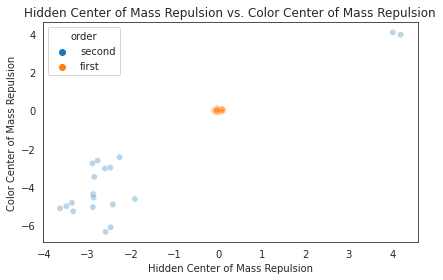

In [81]:

def plot_hidden_distortion_vs_color_distortion():
    title = 'Hidden Center of Mass Repulsion vs. Color Center of Mass Repulsion'
    try:
        plt.clf()
        hidden_distortion = calc_error(hidden_center_of_mass_df, true_val_dict) 
        _cond = (hidden_distortion["time"] == "post") & (hidden_distortion["stim"].str.contains("med"))
        hidden_distortion = hidden_distortion[_cond]

        _cond = color_center_of_mass_df["time"] == "post"
        color_distortion = color_center_of_mass_df[_cond]

        color_distortion = (color_distortion.set_index(["run", "time", "type","stim"]))
        hidden_distortion = (hidden_distortion.set_index(["run", "time", "type","stim"]))
        merged = pd.merge(color_distortion, hidden_distortion, left_index=True, right_index=True, how="left", suffixes=('_color', '_hidden'))
        merged["rev_error_hidden"] += 0.1*np.random.randn(len(merged["rev_error_hidden"]))
        merged["rev_error_color"] += 0.1*np.random.randn(len(merged["rev_error_color"]))
        display(merged)
        plt.title(title)
        plt.xlabel("Hidden Center of Mass Repulsion")
        plt.ylabel("Color Center of Mass Repulsion")
        sns.scatterplot(data=merged, x="rev_error_hidden", y="rev_error_color", hue="order", alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
    except:
        traceback.print_exc()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        
plot_hidden_distortion_vs_color_distortion()

### How Many in each category
<a id='How_Many_in_each_category'></a>

In [82]:
codeprofiler.disable()


## Add necessary checkpoint info
<a id='Add_necessary_checkpoint_info'></a>

In [83]:
if results_df['TF'].sum() == len(results_df['TF']) :
    all_results_true = True
    temp = ['ALL RESULTS MET', all_results_true, 1, 'Only add if all resulting predictions are met']
    temp_series = pd.Series(temp, index = results_df.columns)
    results_df = results_df.append(temp_series, ignore_index = True)

else :
    all_results_true = False



In [85]:
checkpoints_df['OscAmnt_Face'] = parameter_values['OscAmnt']['Face']
checkpoints_df['Gi_Face'] = parameter_values['Gi']['Face']
checkpoints_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
checkpoints_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
checkpoints_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
checkpoints_df['Gi_Out'] = parameter_values['Gi']['Output']
checkpoints_df['dir_name'] = data_file

checkpoints_df.to_csv(checkpoint_fig_dir + 'checkpoints.csv')

results_df['OscAmnt_Face'] = parameter_values['OscAmnt']['Face']
results_df['Gi_Face'] = parameter_values['Gi']['Face']
results_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
results_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
results_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
results_df['Gi_Out'] = parameter_values['Gi']['Output']
results_df['dir_name'] = data_file
results_df.to_csv(results_fig_dir + 'results.csv')


analyses_df['dir_name'] = data_file
analyses_df.to_csv(figDir + 'analyses.csv')

center_of_mass_df.to_csv(results_fig_dir + 'center_of_mass.csv')
color_center_of_mass_all_epochs_df.to_csv(results_fig_dir + 'color_center_of_mass_all.csv')
    
## correlation df:
hidden_corr_long['layer'] = 'hidden'
output_corr_long['layer'] = 'output'
corr_df = hidden_corr_long.append(output_corr_long)
corr_df['overlap'] = parameter_values['overlap']['overlapType']
corr_df.to_csv(results_fig_dir + 'correlation.csv')


repulsion_count_each_run.to_csv(results_fig_dir + 'repulsion_count_each_run.csv')
df_pre_post_corr.to_csv(results_fig_dir + 'pre_post_corr.csv')

with open(f"{dataDir}/codeprofiler.txt", "w", encoding="utf-8") as f:
    s = io.StringIO()
    ps = pstats.Stats(codeprofiler, stream=s).sort_stats("cumtime")
    ps.print_stats()
    f.write(s.getvalue())



## Save
<a id='Save'></a>

In [ ]:
if from_cmdLine != 'cmd' :
    os.system('ipython nbconvert --to HTML Post_analyses.ipynb')
    os.system('mv Post_analyses.html ' + dataDir + data_file + '_analysis.html')
    print(data_file)

In [ ]:
print('done with analysis!')